<a href="https://colab.research.google.com/github/younesBoutiyarzist/FixMatch/blob/main/FixMatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CREATE MODEL

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.layers import Dense, Flatten,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

def create_model(image_size=32):
# initialize the model along with the input shape to be
# "channels last" and the channels dimension itself
  model = Sequential()
  chanDim = -1

  # CONV => RELU => POOL
  model.add(Conv2D(32, (3, 3), padding="same",input_shape=(image_size,image_size,3)))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))


  # (CONV => RELU) * 2 => POOL
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))


  # (CONV => RELU) * 2 => POOL
  model.add(Conv2D(128, (3, 3), padding="same"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))


  # (CONV => RELU) * 2 => POOL
  model.add(Conv2D(256, (3, 3), padding="same"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation("relu"))
  model.add(Dropout(0.5))

  # softmax classifier
  model.add(Dense(18,activation='softmax'))



  return model

IMPORT DATA

animal data :

In [3]:
!git clone https://github.com/axelcarlier/projsemisup.git
path = "./projsemisup/"

Cloning into 'projsemisup'...
remote: Enumerating objects: 48161, done.
remote: Total 48161 (delta 0), reused 0 (delta 0), pack-reused 48161
Receiving objects: 100% (48161/48161), 2.96 GiB | 30.09 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Checking out files: 100% (22857/22857), done.


In [4]:
import os

CLASSES = os.listdir(path + 'Lab/')
print(CLASSES)

['hyène', 'Gorilla', 'autruche', 'Hippopotame', 'Guepard', 'Lion', 'Girafe', 'tigre', 'Rhinoceros', 'Gnou', "Buffle d'Afrique", 'Phacochère', 'Zèbre', 'Chimpanzé', 'antilope', 'Leopard', 'Chacal', 'Elephant']


In [5]:
IMAGE_SIZE = 32

In [6]:
import os
import PIL
from PIL import Image
import numpy as np

def load_semisup_data(path, classes, image_size=64, nb_unlab=7*360):

  file_path_lab = os.listdir(path + 'Lab/')
  nb_lab = 360
  # Initialise les structures de données
  x_lab = np.zeros((nb_lab, image_size, image_size, 3))
  y_lab = np.zeros((nb_lab, 1))
  i = 0
  for c in file_path_lab:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Lab/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Lab/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      img = img.convert('RGB')
      # Remplissage de la variable x
      x_lab[i] = np.asarray(img)
      y_lab[i] = class_label
      i = i + 1


  file_path_test = os.listdir(path + 'Test/')
  nb_test = 1800
  # Initialise les structures de données
  x_test = np.zeros((nb_test, image_size, image_size, 3))
  y_test = np.zeros((nb_test, 1))
  i = 0
  for c in file_path_test:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Test/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Test/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      img = img.convert('RGB')
      # Remplissage de la variable x
      x_test[i] = np.asarray(img)
      y_test[i] = class_label
      i = i + 1

  x_unlab = np.zeros((nb_unlab, image_size, image_size, 3))
  i = 0
  list_images = os.listdir(path + 'Unlab/')
  nb_unlab_dir = len(list_images)
  for img_name in list_images:
    # Lecture de l'image
    img = Image.open(path + 'Unlab/' + img_name)
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.ANTIALIAS)
    img = img.convert('RGB')
    # Remplissage de la variable x
    x_unlab[i] = np.asarray(img)
    i = i + 1
    if (i >= nb_unlab or i >= nb_unlab_dir):
      break;



  return x_lab, y_lab, x_test, y_test, x_unlab

x_lab, y_lab, x_test, y_test, x_unlab = load_semisup_data(path, CLASSES, image_size=IMAGE_SIZE)

In [7]:
import imgaug.augmenters as iaa
aug_strong = iaa.RandAugment(m=(4, 9))
aug_weak = iaa.RandAugment(m=(0, 3))

def randaugment_weak(img):
  return aug_weak(images=img)

def randaugment_strong(img):
  return aug_strong(images=img)

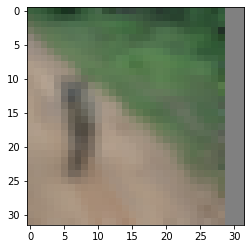

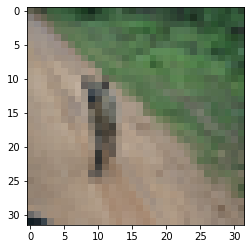

In [8]:
import matplotlib.pyplot as plt

# Augmentation puis des données
x_batch_augment = randaugment_strong(x_lab.astype('uint8'))
#x_batch_augment = train_lab_X.astype('float')/255
plt.imshow(x_batch_augment[1,:,:].astype('float')/255)
plt.show()
plt.imshow(x_lab[1,:,:].astype('float')/255)
plt.show()

In [9]:
# Nombre d'epochs de l'apprentissage
epochs = 2000
# Nombre de données non-labellisées par batch
mu = 3
# Nombre de données labellisées par batch
bs_lab = 64
bs_unlab = bs_lab *mu

# Taille du batch
batch_size = bs_lab + bs_unlab
# Valeur initiale du paramètre de contrôle de l'importance de la régularisation non-supervisée
lambda_t = 1
tau = 0.95
model = create_model()
  

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       2

In [11]:
train_lab_X = x_lab
train_lab_y = y_lab
test_X = x_test
test_y = y_test
train_unlab_X = x_unlab

In [12]:

# Nombre de batches par epochs
steps_per_epochs = int(np.floor(train_lab_X.shape[0]/bs_lab))
# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# ICI ON A BESOIN DE DEUX FONCTIONS DE COUT : 
# perte
loss = keras.losses.CategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

# Indices de l'ensemble  labellisé
indices_lab = np.arange(train_lab_X.shape[0]) 
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(train_unlab_X.shape[0]) 
          

In [13]:
import sys

In [15]:

for epoch in range(epochs):

  for b in range(steps_per_epochs):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = train_lab_X[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = train_lab_y[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    #y_batch_lab = np.expand_dims(train_lab_y, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = train_unlab_X[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:
      # Application du réseau aux données d'entrée labelisé
      y_lab_pred = model(x_batch_lab, training=False)

      # Calcul loss on lab
      sup_term = loss(tf.squeeze(tf.one_hot(y_batch_lab, 18)), y_lab_pred)
      unsup_term = 0

      # weak augmentation
      x_batch_unlab_weak = randaugment_weak(x_batch_unlab.astype('uint8'))

      # strong augmentation
      x_batch_unlab_strong = randaugment_strong(x_batch_unlab.astype('uint8'))

      # Application du réseau aux données d'entrée non labelisé
      y_unlab_weak_pred = model(x_batch_unlab_weak, training=False)
      y_unlab_strong_pred = model(x_batch_unlab_strong, training=True)

      # get correct prediction
      res = np.amax(y_unlab_weak_pred,1) > tau
      aux = np.argmax(y_unlab_weak_pred, axis=1)
      print(sum(res))
      if sum(res) > 0 :
        y_unlab_weak_pred_filter = y_unlab_weak_pred[res]
        x_batch_unlab_weak_filter = x_batch_unlab_weak[res]
        
        # keep prediction on strong augmentation
        y_unlab_strong_pred_filter = y_unlab_strong_pred[res]
        x_batch_unlab_weak_filter = x_batch_unlab_strong[res]

        # Calcul loss on unlab
        unsup_term = loss(y_unlab_weak_pred_filter, y_unlab_strong_pred_filter)

      # Calcul de la fonction de perte sur ce batch
      loss_value = sup_term + lambda_t * unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(tf.squeeze(tf.one_hot(y_batch_lab, 18)), y_lab_pred)

  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = model(x_test, training=False)
  val_acc_metric.update_state(tf.squeeze(tf.one_hot(y_test, 18)), val_logits)
  val_acc = val_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()



65
0
10
0
0
Epoch    0 : Loss : 5.6135, Acc : 0.0000, Val Acc : 0.0550
0
0
0
0
0
Epoch    1 : Loss : 2.9598, Acc : 0.0000, Val Acc : 0.0556
0
0
0
0
0
Epoch    2 : Loss : 2.7693, Acc : 0.0656, Val Acc : 0.0700
0
0
0
0
0
Epoch    3 : Loss : 2.7374, Acc : 0.0656, Val Acc : 0.0717
0
0
0
0
0
Epoch    4 : Loss : 2.7185, Acc : 0.0844, Val Acc : 0.0639
0
0
0
0
0
Epoch    5 : Loss : 2.7234, Acc : 0.0750, Val Acc : 0.0872
0
0
0
0
0
Epoch    6 : Loss : 2.7722, Acc : 0.0719, Val Acc : 0.0972
0
0
0
0
0
Epoch    7 : Loss : 2.7436, Acc : 0.0969, Val Acc : 0.0994
0
0
0
0
0
Epoch    8 : Loss : 2.6659, Acc : 0.1250, Val Acc : 0.1044
0
0
0
0
0
Epoch    9 : Loss : 2.5516, Acc : 0.1344, Val Acc : 0.1106
0
0
1
3
17
Epoch   10 : Loss : 3.9279, Acc : 0.1094, Val Acc : 0.0750
20
23
23
15
13
Epoch   11 : Loss : 3.6920, Acc : 0.1094, Val Acc : 0.0867
8
19
58
33
20
Epoch   12 : Loss : 4.1357, Acc : 0.0844, Val Acc : 0.0950
9
5
3
2
4
Epoch   13 : Loss : 3.1036, Acc : 0.0437, Val Acc : 0.0872
7
11
24
34
47
Epoch   

KeyboardInterrupt: ignored